### Notebook 2: Cleaning data and doing EDA to prep for modelling.

##### Step 1: Read in both datasets

In [237]:
#necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer

import re
from nltk.tokenize import RegexpTokenizer

import warnings
warnings.filterwarnings('ignore')

In [2]:
got = pd.read_csv('./data/got_5100_posts.csv', index_col=0)

In [9]:
got.head(2)

,subreddit,selftext,title
0,gameofthrones,NaN,Some genius explains how the Trump riots is ‘G...
1,gameofthrones,NaN,"Jagjeet Sandhu Age, Career, Personal Life- Bio..."


In [4]:
lotr = pd.read_csv('./data/lotr_5100_posts.csv', index_col=0)

In [5]:
lotr.head(2)

,subreddit,selftext,title
0,lotr,NaN,Start my Tolkien journey off right
1,lotr,Hi guys!\n\nThis might seem like an unusual re...,Looking for posters


Step 2: Explore the data for any cleaning needed

In [6]:
#I'll start with the GoT data
got.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5100 entries, 0 to 5099
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  5100 non-null   object
 1   selftext   1388 non-null   object
 2   title      5100 non-null   object
dtypes: object(3)
memory usage: 159.4+ KB


In [10]:
lotr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5100 entries, 0 to 5099
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  5100 non-null   object
 1   selftext   1619 non-null   object
 2   title      5100 non-null   object
dtypes: object(3)
memory usage: 159.4+ KB


In [26]:
got.isna().sum()

subreddit       0
selftext     3712
title           0
dtype: int64

In [27]:
lotr.isna().sum()

subreddit       0
selftext     3481
title           0
dtype: int64

First observation: the 'selftext' columns in both datasets have quite a few nulls, whereas the 'title' columns don't have any. The 'selftext' column is the description text related to the post's title, if the reddit user decided to add a description to their post. Since there are so many nulls, I'm going to not use this data for my first pass at modelling. I'll just stick with the 'title' columns in each dataset for now and move forward. 

Also, at this point, I should maybe combine the datasets into one big one so I don't have to do everything twice. I'll combine both datasets, then make a master dataframe without the 'selftext' information.

In [17]:
combined_data = pd.concat([got, lotr], ignore_index=True)
combined_data

,subreddit,selftext,title
0,gameofthrones,NaN,Some genius explains how the Trump riots is ‘G...
1,gameofthrones,NaN,"Jagjeet Sandhu Age, Career, Personal Life- Bio..."
2,gameofthrones,NaN,"Kaagaz: plot, cast, review. Kaagaz is a 2021 I..."
3,gameofthrones,NaN,"Urvi Singh Age, Career, Personal Life- Biograp..."
4,gameofthrones,NaN,"Abhishek Banerjee: Wiki, age, birthday &amp; f..."
...,...,...,...
10195,lotr,I read the lotr for the first time a few month...,lotr is calling me back
10196,lotr,NaN,"Fly, you fools!"
10197,lotr,NaN,Cool fire pit
10198,lotr,NaN,Who remembers when LOTR first premiered?


In [24]:
#I'm also going to export this combined dataframe so I can easily pull it in later
combined_data.to_csv('./data/combined_data_with_selftext.csv')

In [18]:
all_titles = combined_data.drop('selftext', axis=1)

In [20]:
all_titles

,subreddit,title
0,gameofthrones,Some genius explains how the Trump riots is ‘G...
1,gameofthrones,"Jagjeet Sandhu Age, Career, Personal Life- Bio..."
2,gameofthrones,"Kaagaz: plot, cast, review. Kaagaz is a 2021 I..."
3,gameofthrones,"Urvi Singh Age, Career, Personal Life- Biograp..."
4,gameofthrones,"Abhishek Banerjee: Wiki, age, birthday &amp; f..."
...,...,...
10195,lotr,lotr is calling me back
10196,lotr,"Fly, you fools!"
10197,lotr,Cool fire pit
10198,lotr,Who remembers when LOTR first premiered?


In [21]:
#I'd like to make a title_length column just to see what those are like between the two datasets
#df['status_length']  = df['STATUS'].str.len()
all_titles['title_word_length'] = all_titles['title'].str.lower().str.split(" ").str.len()

In [22]:
all_titles.head()

,subreddit,title,title_word_length
0,gameofthrones,Some genius explains how the Trump riots is ‘G...,14
1,gameofthrones,"Jagjeet Sandhu Age, Career, Personal Life- Bio...",25
2,gameofthrones,"Kaagaz: plot, cast, review. Kaagaz is a 2021 I...",21
3,gameofthrones,"Urvi Singh Age, Career, Personal Life- Biograp...",24
4,gameofthrones,"Abhishek Banerjee: Wiki, age, birthday &amp; f...",23


In [23]:
all_titles.describe()

,title_word_length
count,10200.000000
mean,14.515196
std,10.246274
min,1.000000
25%,6.000000
50%,12.000000
75%,23.000000
max,61.000000


/Users/melissamcmillan/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/melissamcmillan/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


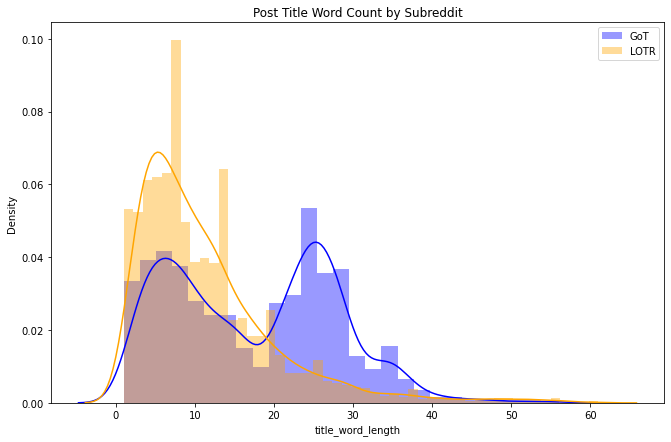

In [198]:
all_titles_got = all_titles[all_titles['subreddit'] == 'gameofthrones']
all_titles_lotr = all_titles[all_titles['subreddit'] == 'lotr']

fig, ax = plt.subplots(figsize=(11,7))
sns.distplot(all_titles_got['title_word_length'], color = 'blue', label = 'GoT')
sns.distplot(all_titles_lotr['title_word_length'], color = 'orange', label = 'LOTR')
plt.title('Post Title Word Count by Subreddit')
plt.legend()

Hmmm this is interesting: the LOTR title lengths seem to be more normally distributed, although right-skewed, while the GoT title 
lengths have a bimodal distribution.

In [28]:
#Now I'd like to make a column of the character lengths for the titles and see how those compare between the subreddits
all_titles['title_character_total']  = all_titles['title'].str.len()

In [29]:
all_titles.head(2)

,subreddit,title,title_word_length,title_character_total
0,gameofthrones,Some genius explains how the Trump riots is ‘G...,14,78
1,gameofthrones,"Jagjeet Sandhu Age, Career, Personal Life- Bio...",25,160


/Users/melissamcmillan/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/melissamcmillan/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


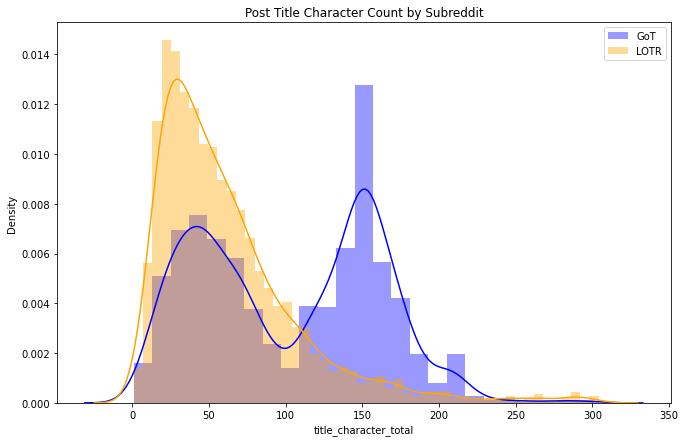

In [205]:
all_titles_got = all_titles[all_titles['subreddit'] == 'gameofthrones']
all_titles_lotr = all_titles[all_titles['subreddit'] == 'lotr']

fig, ax = plt.subplots(figsize=(11,7))
sns.distplot(all_titles_got['title_character_total'], color = 'blue', label = 'GoT')
sns.distplot(all_titles_lotr['title_character_total'], color = 'orange', label = 'LOTR')
plt.title('Post Title Character Count by Subreddit')
plt.legend()

Similar distributions here as with the title word length. Good to know!

In [31]:
#Just going to do a quick .describe() so that I have this information handy
all_titles.groupby('subreddit').describe()

title_word_length                                              \
                          count       mean        std  min  25%   50%   75%   
subreddit                                                                     
gameofthrones            5100.0  17.687451  10.506265  1.0  8.0  18.0  26.0   
lotr                     5100.0  11.342941   8.915207  1.0  5.0   9.0  15.0   

                    title_character_total                                    \
                max                 count        mean        std  min   25%   
subreddit                                                                     
gameofthrones  56.0                5100.0  103.074902  58.499599  1.0  48.0   
lotr           61.0                5100.0   61.921373  47.182632  1.0  29.0   

                                     
                 50%     75%    max  
subreddit                            
gameofthrones  114.5  152.25  301.0  
lotr            50.0   79.00  304.0

I'm now going to map the subreddit column as 1 = GoT and 0 = LOTR so I can look at a heatmap of the title stats.

In [32]:
all_titles['subreddit_map'] = all_titles['subreddit'].map({'gameofthrones': 1, 'lotr': 0})

,subreddit,title,title_word_length,title_character_total,subreddit_map
0,gameofthrones,Some genius explains how the Trump riots is ‘G...,14,78,1
1,gameofthrones,"Jagjeet Sandhu Age, Career, Personal Life- Bio...",25,160,1


In [33]:
all_titles

,subreddit,title,title_word_length,title_character_total,subreddit_map
0,gameofthrones,Some genius explains how the Trump riots is ‘G...,14,78,1
1,gameofthrones,"Jagjeet Sandhu Age, Career, Personal Life- Bio...",25,160,1
2,gameofthrones,"Kaagaz: plot, cast, review. Kaagaz is a 2021 I...",21,129,1
3,gameofthrones,"Urvi Singh Age, Career, Personal Life- Biograp...",24,156,1
4,gameofthrones,"Abhishek Banerjee: Wiki, age, birthday &amp; f...",23,154,1
...,...,...,...,...,...
10195,lotr,lotr is calling me back,5,23,0
10196,lotr,"Fly, you fools!",3,15,0
10197,lotr,Cool fire pit,3,13,0
10198,lotr,Who remembers when LOTR first premiered?,6,40,0


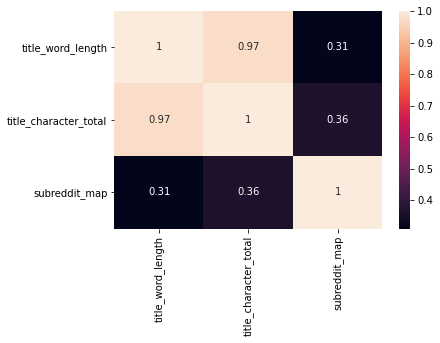

In [34]:
sns.heatmap(all_titles.corr(), annot=True)

It looks like there might be some initial correlations between title_word_length/title_character_total and the subreddit_map because the correlation numbers are 0.31/0.36. Not super high numbers, but it's not zero. Again, good to know! I might want to use the title_character_total column in my modelling. 

Alright, now I'm going to apply a CountVectorizer to my dataset and explore the results

In [36]:
#I'm going to first initialize without any stop_words just to see what comes up
cvect= CountVectorizer()

In [37]:
all_cvect = all_titles['title'].copy()
all_cvect = cvect.fit_transform(all_cvect)

In [38]:
all_cvect_df = pd.DataFrame(all_cvect.toarray(), columns = cvect.get_feature_names())

In [39]:
all_cvect_df.shape

(10200, 9708)

In [40]:
all_cvect_df.sum().sort_values(ascending=False).head(15)

the         6971
of          3346
and         2526
to          2176
in          1952
is          1801
for         1559
spoilers    1469
my          1378
bigg        1198
boss        1140
14          1122
this        1061
no          1028
it          1018
dtype: int64

In [41]:
all_cvect_df.sum().sort_values(ascending=True).head(15)

lockscreen         1
lotfmeme           1
lors               1
lorna              1
lordsheogorath1    1
looooooove         1
longtime           1
longbottom         1
lothlorian         1
loneliness         1
lohri              1
logic              1
𝐏𝐂                 1
locked             1
lockdowns          1
dtype: int64

In [42]:
#I'm going to run the CountVectorizer again, but this time I'm going to filter out the stop words since they
#seem to coming up in the top word counts
cvect_stop = CountVectorizer(stop_words = 'english')

In [44]:
all_cvect = all_titles['title'].copy()
all_cvect_stop = cvect_stop.fit_transform(all_cvect)

In [45]:
all_cvect_stop_df = pd.DataFrame(all_cvect_stop.toarray(), columns = cvect_stop.get_feature_names())

In [46]:
all_cvect_stop_df.shape

(10200, 9442)

In [204]:
all_cvect_stop_df.sum().sort_values(ascending=False).head(20)

spoilers      1469
bigg          1198
boss          1140
14            1122
episode        955
roadies        859
revolution     805
mtv            608
lotr           579
got            538
new            449
season         393
game           355
series         351
just           341
4k             320
indian         310
rubina         299
rahul          299
hobbit         297
dtype: int64

In [228]:
top_words = all_cvect_stop_df.sum().sort_values(ascending=False).head(10)

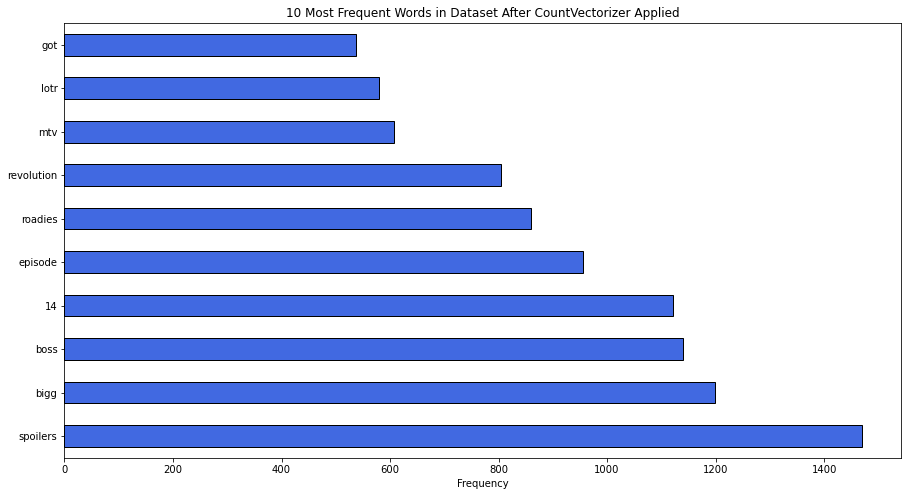

In [236]:
fig, ax = plt.subplots(figsize = (15, 8))

top_words.plot.barh(color='royalblue', edgecolor = 'black')
plt.title('10 Most Frequent Words in Dataset After CountVectorizer Applied')
plt.xlabel('Frequency');

In [48]:
all_cvect_stop_df.sum().sort_values(ascending=True).head(15)

𝟐𝟎𝟕𝟕             1
experts          1
recruit          1
recreating       1
recovery         1
records          1
explicitly       1
explore          1
exponentially    1
exposed          1
reconstructed    1
recommended      1
exquisite        1
ext              1
recruitment      1
dtype: int64

From my initial Naive Bayes modelling in the 03_Naive_Bayes_Modelling notebook, I've learned that I have emojis and lots of symbols in this dataset that I'd like to get rid of. So, I'm going to try get rid of them here using the re/Regular Expressions library tools.

In [175]:
all_titles['title_token'] = all_titles['title'].copy()

In [176]:
tokenizer_regex = RegexpTokenizer('[a-zA-Z\d]+')

In [170]:
test_title = all_titles['title'][4117]

In [171]:
test_title

'BIGG BOSS 14: राहुल वैद्य के प्रशंसक रोस्ट टास्क के बाद रुबीना से नाखुश हाल ही में बिग बॉस के एपिसोड में उन्होंने एक सेगमेंट को दिखाया, जहां हाउसफुल को अच्छी आस्थ...'

In [174]:
tokenizer_regex.tokenize(test_title)

['BIGG', 'BOSS', '14']

In [ ]:
#Okay, that did what I wanted, I'm going to apply it to my dataset now

In [177]:
all_titles.head(2)

,subreddit,title,title_word_length,title_character_total,subreddit_map,title_token
0,gameofthrones,Some genius explains how the Trump riots is ‘G...,14,78,1,Some genius explains how the Trump riots is ‘G...
1,gameofthrones,"Jagjeet Sandhu Age, Career, Personal Life- Bio...",25,160,1,"Jagjeet Sandhu Age, Career, Personal Life- Bio..."


In [178]:
for idx, element in enumerate(all_titles['title_token']):
    all_titles['title_token'][idx] = tokenizer_regex.tokenize(all_titles['title_token'][idx]) 

<ipython-input-178-cd9aa0d317ee>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_titles['title_token'][idx] = tokenizer_regex.tokenize(all_titles['title_token'][idx])


In [179]:
all_titles['title'].head(2)

0    Some genius explains how the Trump riots is ‘G...
1    Jagjeet Sandhu Age, Career, Personal Life- Bio...
Name: title, dtype: object

In [180]:
all_titles['title_token'].head()

0    [Some, genius, explains, how, the, Trump, riot...
1    [Jagjeet, Sandhu, Age, Career, Personal, Life,...
2    [Kaagaz, plot, cast, review, Kaagaz, is, a, 20...
3    [Urvi, Singh, Age, Career, Personal, Life, Bio...
4    [Abhishek, Banerjee, Wiki, age, birthday, amp,...
Name: title_token, dtype: object

In [181]:
all_titles['title_token'][0]

['Some',
 'genius',
 'explains',
 'how',
 'the',
 'Trump',
 'riots',
 'is',
 'Game',
 'Of',
 'Thrones',
 'S8',
 'but',
 'better']

In [182]:
" ".join(all_titles['title_token'][0])

'Some genius explains how the Trump riots is Game Of Thrones S8 but better'

In [183]:
for idx, element in enumerate(all_titles['title_token']):
    all_titles['title_token'][idx] = " ".join(all_titles['title_token'][idx])

<ipython-input-183-9f00df1db2e1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_titles['title_token'][idx] = " ".join(all_titles['title_token'][idx])


In [184]:
all_titles['title_token'][0]

'Some genius explains how the Trump riots is Game Of Thrones S8 but better'

In [185]:
all_titles.head(2)

,subreddit,title,title_word_length,title_character_total,subreddit_map,title_token
0,gameofthrones,Some genius explains how the Trump riots is ‘G...,14,78,1,Some genius explains how the Trump riots is Ga...
1,gameofthrones,"Jagjeet Sandhu Age, Career, Personal Life- Bio...",25,160,1,Jagjeet Sandhu Age Career Personal Life Biogra...


In [186]:
#remember above: cvect_stop = CountVectorizer(stop_words = 'english')
cvect_test = all_titles['title_token'].copy()
cvect_test_token_stop = cvect_stop.fit_transform(cvect_test)

In [187]:
cvect_test_token_stop_df = pd.DataFrame(cvect_test_token_stop.toarray(), 
                                 columns = cvect_stop.get_feature_names())

In [188]:
cvect_test_token_stop_df.shape

(10200, 8914)

In [189]:
cvect_test_token_stop_df.sum().sort_values(ascending=False).head(15)

spoilers      1469
bigg          1198
boss          1140
14            1125
episode        955
roadies        859
revolution     805
mtv            608
lotr           579
got            538
new            449
season         393
game           355
series         351
just           342
dtype: int64

In [190]:
cvect_test_token_stop_df.sum().sort_values(ascending=True).head(15)

𝟐𝟎𝟕𝟕           1
prepares       1
envy           1
enya           1
preparation    1
eorlingas      1
preordered     1
ep02           1
prenamed       1
ep9            1
premiums       1
epics          1
epipdes        1
presence       1
premiering     1
dtype: int64

In [191]:
all_titles.head()

,subreddit,title,title_word_length,title_character_total,subreddit_map,title_token
0,gameofthrones,Some genius explains how the Trump riots is ‘G...,14,78,1,Some genius explains how the Trump riots is Ga...
1,gameofthrones,"Jagjeet Sandhu Age, Career, Personal Life- Bio...",25,160,1,Jagjeet Sandhu Age Career Personal Life Biogra...
2,gameofthrones,"Kaagaz: plot, cast, review. Kaagaz is a 2021 I...",21,129,1,Kaagaz plot cast review Kaagaz is a 2021 India...
3,gameofthrones,"Urvi Singh Age, Career, Personal Life- Biograp...",24,156,1,Urvi Singh Age Career Personal Life Biography ...
4,gameofthrones,"Abhishek Banerjee: Wiki, age, birthday &amp; f...",23,154,1,Abhishek Banerjee Wiki age birthday amp facts ...


In [192]:
all_titles.isna().sum()

subreddit                0
title                    0
title_word_length        0
title_character_total    0
subreddit_map            0
title_token              0
dtype: int64

In [193]:
all_titles.to_csv('./data/combined_data_cleaned_with_regexp.csv')

Now that I've cleaned up the data quite a bit, I wonder if the distributions of title word length and title character total are the same for the two subreddits. I'm going to remake those plots and find out.

In [200]:
all_titles['title_token_word_length'] = all_titles['title_token'].str.lower().str.split(" ").str.len()
all_titles['title_token_character_total']  = all_titles['title_token'].str.len()

In [201]:
all_titles.head(2)

,subreddit,title,title_word_length,title_character_total,subreddit_map,title_token,title_token_character_total,title_token_word_length
0,gameofthrones,Some genius explains how the Trump riots is ‘G...,14,78,1,Some genius explains how the Trump riots is Ga...,73,14
1,gameofthrones,"Jagjeet Sandhu Age, Career, Personal Life- Bio...",25,160,1,Jagjeet Sandhu Age Career Personal Life Biogra...,151,25


/Users/melissamcmillan/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/melissamcmillan/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


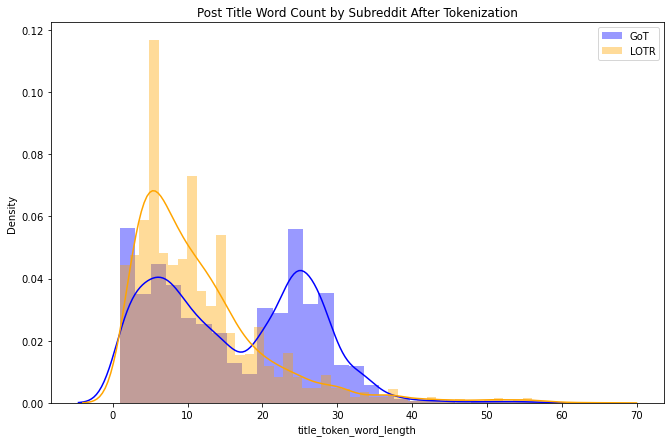

In [202]:
all_titles_got = all_titles[all_titles['subreddit'] == 'gameofthrones']
all_titles_lotr = all_titles[all_titles['subreddit'] == 'lotr']

fig, ax = plt.subplots(figsize=(11,7))
sns.distplot(all_titles_got['title_token_word_length'], color = 'blue', label = 'GoT')
sns.distplot(all_titles_lotr['title_token_word_length'], color = 'orange', label = 'LOTR')
plt.title('Post Title Word Count by Subreddit After Tokenization')
plt.legend()

/Users/melissamcmillan/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/melissamcmillan/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


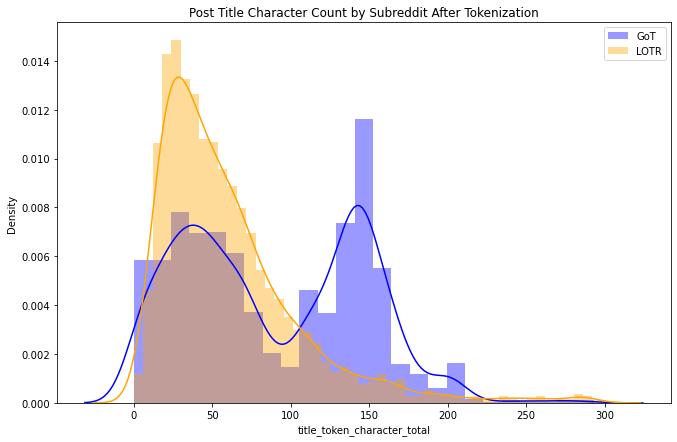

In [203]:
all_titles_got = all_titles[all_titles['subreddit'] == 'gameofthrones']
all_titles_lotr = all_titles[all_titles['subreddit'] == 'lotr']

fig, ax = plt.subplots(figsize=(11,7))
sns.distplot(all_titles_got['title_token_character_total'], color = 'blue', label = 'GoT')
sns.distplot(all_titles_lotr['title_token_character_total'], color = 'orange', label = 'LOTR')
plt.title('Post Title Character Count by Subreddit After Tokenization')
plt.legend();

Hmm, it looks like they didn't change too much. Glad those emojis and non-english characters/symbols didn't have too much impact on the data distributions.